# Label side

In [1]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-06-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

candles.shape

(2848320, 6)

In [2]:
np.save("data/btc_1m.npy", candles)

In [1]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles.shape

(2848320, 6)

In [2]:
from scipy import stats
from custom_indicators.toolbox.bar.fusion.v1 import FusionBarContainerV1

bar_container = FusionBarContainerV1(max_bars=20000)
bar_container.update_with_candles(candles)
merged_bar = bar_container.get_fusion_bars()
close_arr = merged_bar[:, 2]
ret = np.log(close_arr[1:] / close_arr[:-1])
standard = (ret - ret.mean()) / ret.std()
kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
kurtosis

7.074826597929417

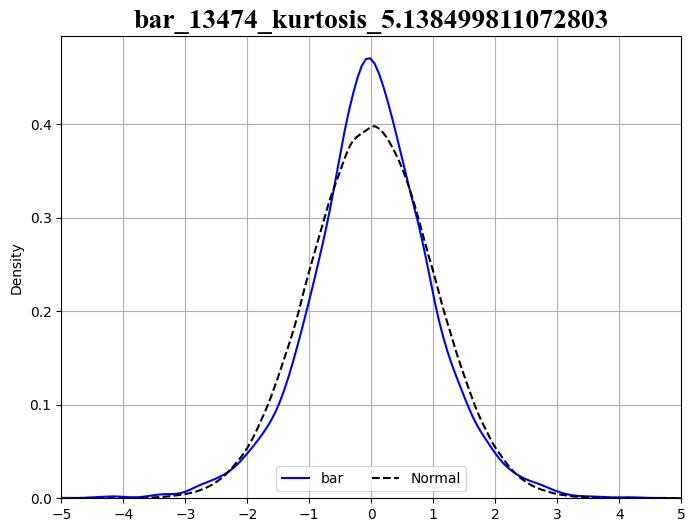

In [3]:
from custom_indicators.utils.plot import plot_kde

L = 5

plot_kde(merged_bar[:, 2], lag=L)

In [4]:
from hmmlearn.hmm import GMMHMM
import pandas as pd
import optuna

from jesse.helpers import timestamp_to_time


def objective(trial: optuna.Trial):
    mix = 3  ### GMM mix参数

    close_arr = merged_bar[:, 2]
    high_arr = merged_bar[:, 3][L:]
    low_arr = merged_bar[:, 4][L:]

    log_return = np.log(close_arr[1:] / close_arr[:-1])[L - 1 :]
    log_return_L = np.log(close_arr[L:] / close_arr[:-L])
    HL_diff = np.log(high_arr / low_arr)

    X = np.column_stack([HL_diff, log_return_L, log_return])

    datelist = np.asarray(
        [pd.Timestamp(timestamp_to_time(i)) for i in merged_bar[:, 0][L:]]
    )
    closeidx = merged_bar[:, 2][L:]

    assert len(datelist) == len(closeidx)
    assert len(datelist) == len(X)

    gmm = GMMHMM(
        n_components=2,
        n_mix=mix,
        covariance_type="diag",
        n_iter=1000,
        # weights_prior=2,
        means_weight=0.5,
        random_state=trial.suggest_int("random_state", 0, 1000),
    )
    gmm.fit(X)
    latent_states_sequence = gmm.predict(X)
    data = pd.DataFrame(
        {
            "datelist": datelist,
            "logreturn": log_return,
            "state": latent_states_sequence,
        }
    ).set_index("datelist")

    final_ret = 0
    for i in data["state"].unique():
        ret = data[data["state"] == i]["logreturn"].sum()
        final_ret += np.abs(ret)

    return final_ret


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)
study.optimize(objective, n_trials=50)

[I 2025-06-08 11:26:31,323] A new study created in memory with name: no-name-e5666519-5cca-4d14-9a07-e14fb7b3ff33
[I 2025-06-08 11:26:35,983] Trial 0 finished with value: 57.71587394563663 and parameters: {'random_state': 741}. Best is trial 0 with value: 57.71587394563663.
[I 2025-06-08 11:26:40,211] Trial 1 finished with value: 53.20537141484954 and parameters: {'random_state': 410}. Best is trial 0 with value: 57.71587394563663.
[I 2025-06-08 11:26:43,402] Trial 2 finished with value: 27.323795258627136 and parameters: {'random_state': 429}. Best is trial 0 with value: 57.71587394563663.
[I 2025-06-08 11:26:47,936] Trial 3 finished with value: 52.25023996119038 and parameters: {'random_state': 448}. Best is trial 0 with value: 57.71587394563663.
[I 2025-06-08 11:26:53,098] Trial 4 finished with value: 53.17647065608698 and parameters: {'random_state': 928}. Best is trial 0 with value: 57.71587394563663.
[I 2025-06-08 11:26:58,184] Trial 5 finished with value: 53.11567668757881 and p

KeyboardInterrupt: 

In [5]:
study.best_params

{'random_state': 741}

In [8]:
from hmmlearn.hmm import GMMHMM  # noqa
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd  # noqa

from jesse.helpers import timestamp_to_time  # noqa

mix = 3  ### GMM mix参数

close_arr = merged_bar[:, 2]
high_arr = merged_bar[:, 3][L:]
low_arr = merged_bar[:, 4][L:]

log_return = np.log(close_arr[1:] / close_arr[:-1])[L - 1 :]
log_return_L = np.log(close_arr[L:] / close_arr[:-L])
HL_diff = np.log(high_arr / low_arr)

X = np.column_stack([HL_diff, log_return_L, log_return])

datelist = np.asarray(
    [pd.Timestamp(timestamp_to_time(i)) for i in merged_bar[:, 0][L:]]
)
closeidx = merged_bar[:, 2][L:]

assert len(datelist) == len(closeidx)
assert len(datelist) == len(X)

gmm = GMMHMM(
    n_components=2,
    n_mix=mix,
    covariance_type="diag",
    n_iter=1000,
    # weights_prior=2,
    means_weight=0.5,
    random_state=741,
)
gmm.fit(X)
latent_states_sequence = gmm.predict(X)

print(np.unique(latent_states_sequence, return_counts=True))

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for i in range(gmm.n_components):
    state = latent_states_sequence == i
    fig.add_trace(
        go.Scatter(
            x=datelist[state],
            y=closeidx[state],
            mode="markers",
            name=f"latent state {i}",
            marker=dict(color=colors[i % len(colors)], size=4),
        )
    )

fig.update_layout(
    title="隐含状态序列",
    xaxis_title="时间",
    yaxis_title="收盘价",
    # width=1400,
    # height=600,
    showlegend=True,
)

fig.show()

(array([0, 1]), array([5946, 7523]))


state 1 (7523) return: -2750.748701%
state 0 (5946) return: 3020.838694%


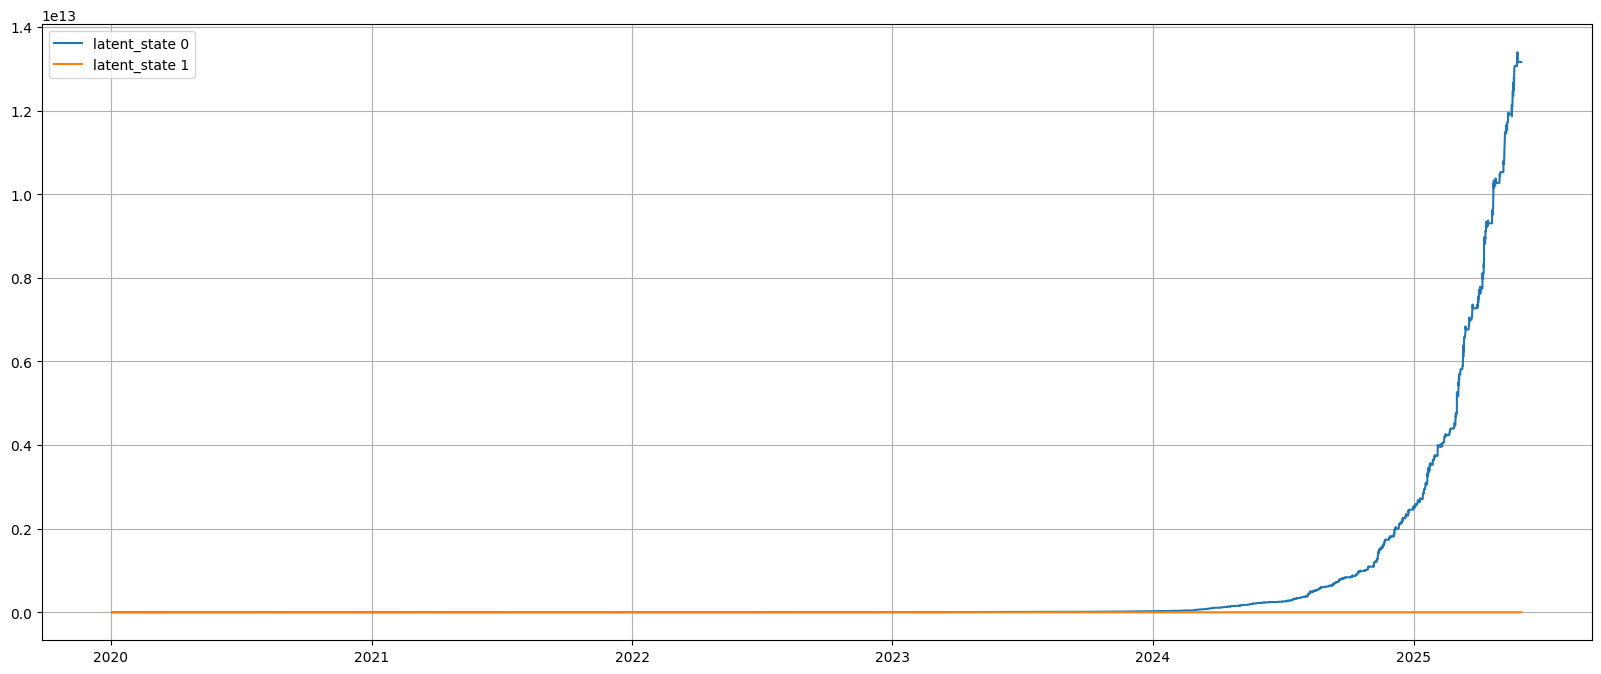

In [9]:
import matplotlib.pyplot as plt

data = pd.DataFrame(
    {
        "datelist": datelist,
        "logreturn": log_return,
        "state": latent_states_sequence,
    }
).set_index("datelist")

for i in data["state"].unique():
    ret = data[data["state"] == i]["logreturn"].sum()
    count = data[data["state"] == i].shape[0]
    print(f"state {i} ({count}) return: {ret:.6%}")

plt.figure(figsize=(20, 8))
for i in range(gmm.n_components):
    state = latent_states_sequence == i
    idx = np.append(0, state[1:])
    data["state %d_return" % i] = data.logreturn.multiply(idx, axis=0)
    plt.plot(np.exp(data["state %d_return" % i].cumsum()), label="latent_state %d" % i)
    plt.legend(loc="upper left")
    plt.grid(1)

In [10]:
assert len(merged_bar[L:]) == len(latent_states_sequence)

In [11]:
# 保存merged bar, 去除最后一个bar，因为需要label前移一位
print(merged_bar[:-1].shape)
np.save("data/merged_bar.npy", merged_bar[:-1])

(13473, 6)


In [12]:
# 上涨下跌统一打标的情况

label = (latent_states_sequence == 0).astype(int)
print(np.unique(label, return_counts=True))
np.save("data/side_label.npy", label)

(array([0, 1]), array([7523, 5946]))


In [69]:
# 上涨下跌分别打标的情况

# label_long = (latent_states_sequence == 1).astype(int)
# print(np.unique(label_long, return_counts=True))
# np.save("data/side_label_long.npy", label_long)

# label_short = (latent_states_sequence == 0).astype(int)
# print(np.unique(label_short, return_counts=True))
# np.save("data/side_label_short.npy", label_short)

(array([0, 1]), array([5981, 2079]))
(array([0, 1]), array([6069, 1991]))


# Label meta

In [1]:
import numpy as np
import pandas as pd
from strategies.BinanceBtcEntropyBarV1.config import SIDE
from strategies.BinanceBtcEntropyBarV1.config import get_side_model

side_model = get_side_model(False)

df_features = pd.read_parquet("data/features.parquet")

side_res = side_model.predict(df_features[SIDE])

side_pred_label = np.where(side_res > 0.5, 1, 0)
print(side_pred_label.shape)

print(np.unique(side_pred_label, return_counts=True))

/opt/homebrew/Caskroom/miniconda/base/envs/jesse/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


(13405,)
(array([0, 1]), array([7486, 5919]))


In [3]:
meta_label = np.full_like(side_pred_label, 0)
print(meta_label.shape)

merged_bar = np.load("data/merged_bar.npy")
log_ret = np.log(merged_bar[1:, 2] / merged_bar[:-1, 2])
len_gap = len(log_ret) - len(side_pred_label)
log_ret = log_ret[len_gap:]
print(log_ret.shape)

for idx, (i, r) in enumerate(zip(side_pred_label[:-1], log_ret[:-1])):
    if i == 1:
        # side模型做多
        if log_ret[idx + 1] > 0:
            # 方向正确
            meta_label[idx] = 1
        else:
            # 方向错误
            meta_label[idx] = 0
    else:
        # side模型做空
        if log_ret[idx + 1] < 0:
            meta_label[idx] = 1
        else:
            meta_label[idx] = 0

print(np.unique(meta_label, return_counts=True))

# meta label复核：对于所有meta label = 1的情况，结合side_pred_label看是否真的盈利
start_idx = 0
end_idx = 0
cumsum_ret = 0
for idx, (meta, side, ret) in enumerate(zip(meta_label, side_pred_label, log_ret)):
    if meta == 1:
        if idx > 0 and meta_label[idx - 1] == 0:
            # 开始持仓
            start_idx = idx
        else:
            # 继续持仓
            cumsum_ret += ret * (1 if side == 1 else -1)
    elif meta == 0:
        if idx > 0 and meta_label[idx - 1] == 1:
            # 结束持仓
            cumsum_ret += ret * (1 if side == 1 else -1)
            end_idx = idx
            if cumsum_ret < 0:
                # 如果收益为负，则认为判断错误
                assert start_idx < end_idx, "start_idx must be less than end_idx"
                meta_label[start_idx:end_idx] = 0
            # 重置收益
            cumsum_ret = 0
            start_idx = 0
            end_idx = 0
        else:
            continue

print(np.unique(meta_label, return_counts=True))

(13405,)
(13405,)
(array([0, 1]), array([5134, 8271]))
(array([0, 1]), array([5260, 8145]))


In [15]:
np.save("data/label_meta.npy", meta_label)